In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
from pyfolio.timeseries import perf_stats
from utils import plot, rolling_sharpe, plot_rolling_sharpe, plot_rolling_vol
%matplotlib inline

In [2]:
cash = 80000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-12-01_19-26_20200101_20200831_adjustedPortfolio_base.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
micro_contracts = df[df.contract.str.startswith('M')]
macro_contracts = df[~df.contract.str.startswith('M')]
micro_contracts['amount'] /= 10
df = pd.concat([macro_contracts, micro_contracts]).sort_index()
df.contract = df.contract.str.strip('M')
df['contract'] = df['contract'].apply(lambda x: x[:2])
df.contract = df.contract.str.strip()

In [4]:
pnl = df.groupby('contract').realizedPNL.sum()
pnl['total'] = pnl.sum()
pnl

contract
ES        53520.36
GC        36466.68
NQ        70566.02
YM        94662.98
total    255216.04
Name: realizedPNL, dtype: float64

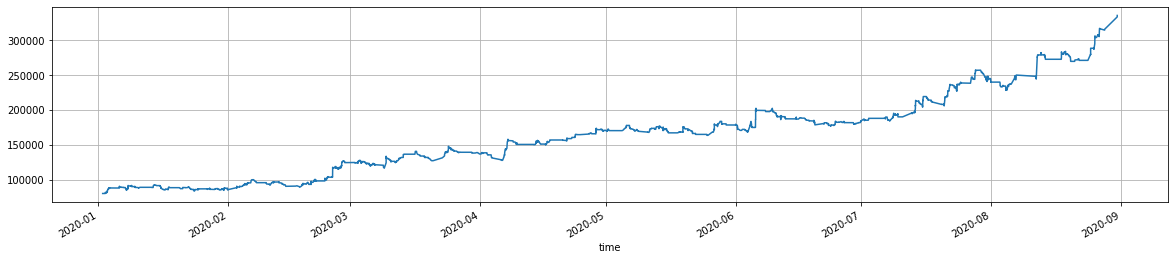

In [5]:
df.cash.plot(figsize=(20,4), grid=True);

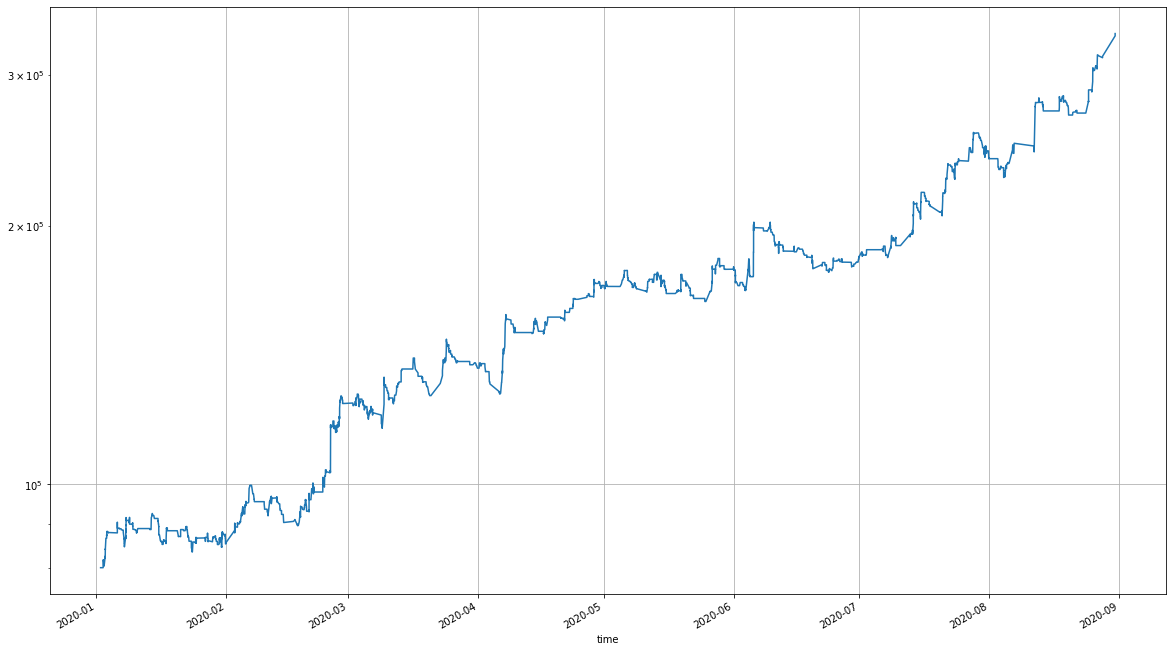

In [6]:
df.cash.plot(figsize=(20,12), grid=True, logy=True);

In [7]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, aggfunc='sum', columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [8]:
#monthly average number of transactions
daily_count = df.groupby('contract').action.resample('B').count()
zero_index = set(daily_count.index.get_level_values(0))
monthly_count = daily_count.groupby('contract').resample('M', level=1).mean()
average_monthly_contracts = pd.DataFrame({contract: monthly_count[contract] for contract in zero_index})
average_monthly_contracts

,GC,YM,ES,NQ
time,,,,
2020-01-31,5.000000,1.545455,1.750000,11.181818
2020-02-29,5.200000,2.100000,2.050000,15.150000
2020-03-31,3.545455,2.727273,1.181818,9.409091
2020-04-30,1.727273,1.545455,2.090909,7.636364
2020-05-31,2.761905,1.523810,1.428571,9.904762
2020-06-30,2.090909,1.636364,2.090909,11.090909
2020-07-31,4.000000,1.391304,1.739130,10.260870
2020-08-31,2.600000,1.176471,1.428571,8.000000


In [9]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     294
 GC     578
 NQ    1772
 YM     290
 Name: action, dtype: int64,
 2934)

In [10]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES     1.699422
 GC     3.341040
 NQ    10.242775
 YM     1.676301
 Name: action, dtype: float64,
 16.959537572254334)

In [11]:
# commission paid
comm = df.groupby('contract').commission.sum()
comm['total'] = comm.sum()
comm

contract
ES       1004.64
GC       2369.32
NQ       5260.48
YM       1154.52
total    9788.96
Name: commission, dtype: float64

In [12]:
# commission paid as percent of pnl
round((comm/pnl) *100, 1)

contract
ES       1.9
GC       6.5
NQ       7.5
YM       1.2
total    3.8
dtype: float64

In [13]:
# per trade stats (pro rated per macro contract)
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss', 
                                'win_ratio', 'EV/contract', 'number_of_contracts'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    d['pnl_per_contract'] = d.realizedPNL / d.amount
    row['average_PNL'] = round(d['pnl_per_contract'].mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0])['pnl_per_contract'].mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0])['pnl_per_contract'].mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV/contract'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_contracts'] = d.amount.sum()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV/contract,number_of_contracts
NQ,0.42,60.40,766.68,-448.41,1.71,61.93,997.2
GC,0.41,150.55,1094.48,-510.19,2.15,147.72,433.0
YM,0.54,309.98,1247.75,-781.76,1.60,314.18,231.8
ES,0.42,222.01,1689.54,-848.42,1.99,217.52,197.6
total,0.43,119.02,978.98,-528.26,1.85,119.85,1859.6


In [14]:
edge = results['win_ratio'] - ((1-results['success_rate'])/ results['success_rate'])
edge

NQ       0.329048
GC       0.710976
YM       0.748148
ES       0.609048
total    0.524419
dtype: float64

In [15]:
daily = by_contract.resample('B').sum()
total_cumsum = (daily['total'].cumsum() + cash).shift(1).fillna(cash)
daily_non_total = daily[daily.columns.drop('total')] * len(daily.columns.drop('total'))
daily_scaled = daily_non_total.copy()
daily_scaled['total'] = daily['total']
daily_scaled

contract,ES,GC,NQ,YM,total
time,,,,,
2020-01-02,0.00,-4226.64,5628.00,0.00,350.34
2020-01-03,0.00,11712.32,11718.24,6472.32,7475.72
2020-01-06,0.00,4496.56,-1579.76,0.00,729.20
2020-01-07,-3954.88,-3305.04,-2546.24,-6009.92,-3954.02
2020-01-08,-2791.12,18925.52,3654.40,1459.20,5312.00
...,...,...,...,...,...
2020-08-25,44634.68,0.00,-14933.44,32099.84,15450.27
2020-08-26,0.00,0.00,49752.16,0.00,12438.04
2020-08-27,0.00,0.00,0.00,0.00,0.00


In [16]:
returns = daily.divide(total_cumsum, axis=0)
returns

contract,ES,GC,NQ,YM,total
time,,,,,
2020-01-02,0.000000,-0.013208,0.017587,0.000000,0.004379
2020-01-03,0.000000,0.036441,0.036460,0.020138,0.093039
2020-01-06,0.000000,0.012800,-0.004497,0.000000,0.008303
2020-01-07,-0.011165,-0.009330,-0.007188,-0.016967,-0.044650
2020-01-08,-0.008248,0.055926,0.010799,0.004312,0.062789
...,...,...,...,...,...
2020-08-25,0.038719,0.000000,-0.012954,0.027845,0.053610
2020-08-26,0.000000,0.000000,0.040962,0.000000,0.040962
2020-08-27,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
returns_scaled = daily_scaled.divide(total_cumsum, axis=0)

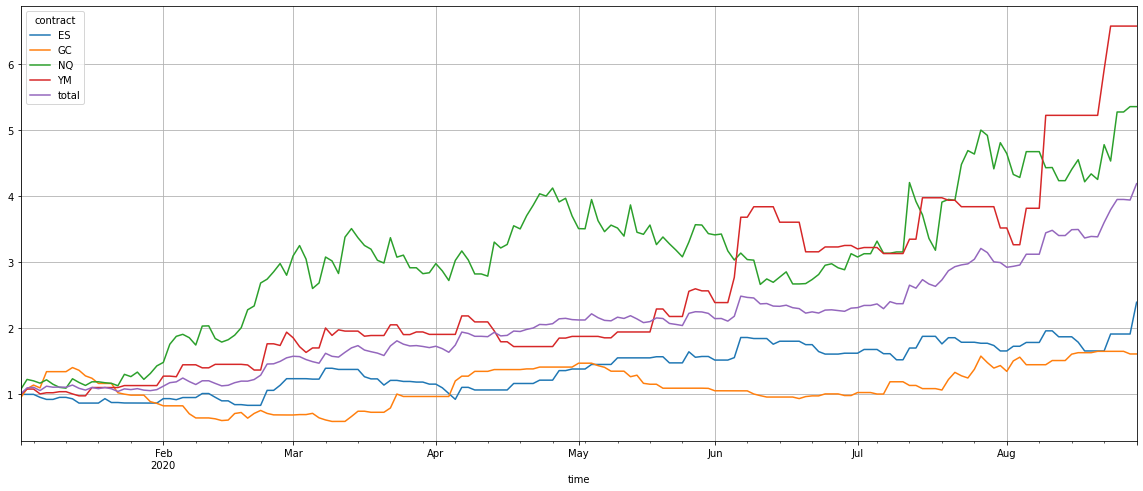

In [18]:
returns_index = (returns_scaled + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(returns_scaled + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,-0.085019,0.108627,0.587767,0.662845
GC,-0.085019,1.000000,0.015957,-0.086370,0.355607
NQ,0.108627,0.015957,1.000000,0.027884,0.577967
YM,0.587767,-0.086370,0.027884,1.000000,0.658545
total,0.662845,0.355607,0.577967,0.658545,1.000000


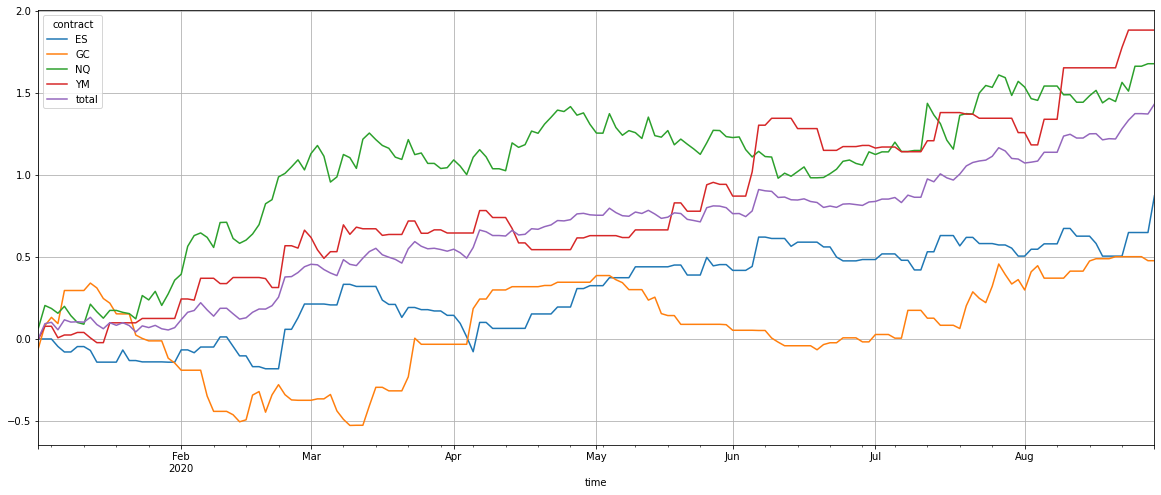

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

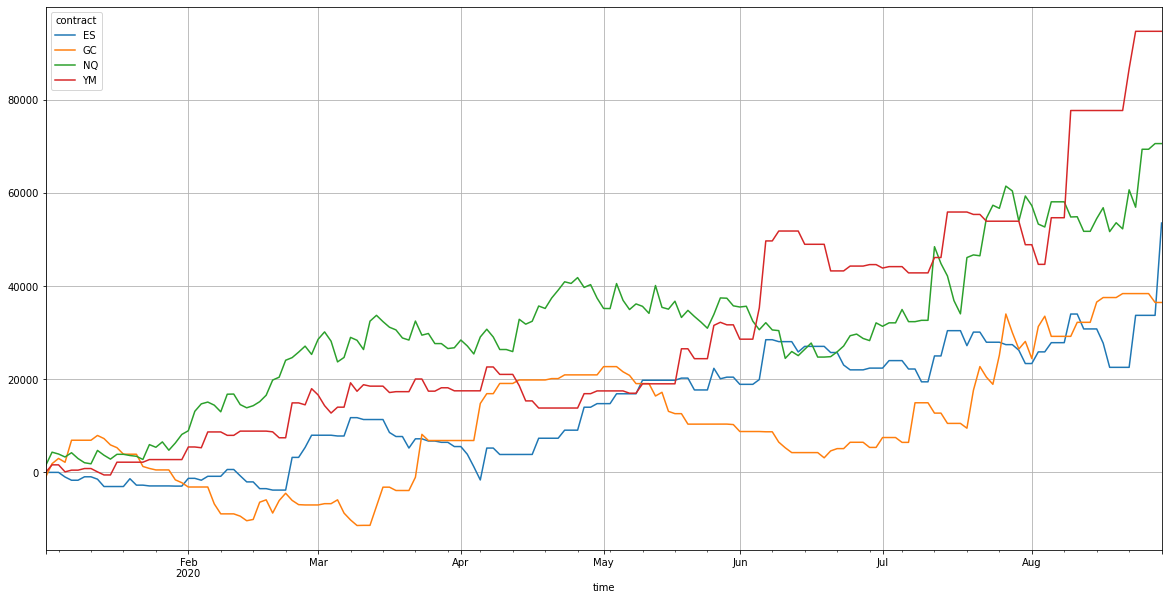

In [21]:
# dollar returns cummulative
by_contract.resample('B').sum().drop('total', axis=1).cumsum().plot(figsize=(20,10), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(returns_scaled[col])
stats

,ES,GC,NQ,YM,total
Annual return,2.568499,1.004270,10.528161,14.541646,7.060773
Cumulative returns,1.394891,0.611741,4.356816,5.576157,3.190201
Annual volatility,0.823296,0.914782,1.134902,1.029190,0.553311
Sharpe ratio,1.929161,1.190329,2.699143,3.137987,4.052878
Calmar ratio,7.620134,1.730838,29.750722,68.574233,68.290509
Stability,0.846070,0.296544,0.683197,0.914429,0.952960
Max drawdown,-0.337067,-0.580222,-0.353879,-0.212057,-0.103393
Omega ratio,1.645966,1.324359,1.609706,2.586446,2.110378
Sortino ratio,4.364653,2.301094,5.427569,9.125154,9.680597
Skew,2.249783,1.659373,1.085770,2.685991,1.268614


In [23]:
#non-scaled returns
stats_non_scaled = pd.DataFrame()
for col in daily.columns:
    stats_non_scaled[col] = perf_stats(returns[col])
stats_non_scaled

,ES,GC,NQ,YM,total
Annual return,0.456666,0.279568,1.065475,1.169069,7.060773
Cumulative returns,0.294637,0.184404,0.645370,0.701588,3.190201
Annual volatility,0.205824,0.228696,0.283726,0.257298,0.553311
Sharpe ratio,1.929161,1.190329,2.699143,3.137987,4.052878
Calmar ratio,4.825219,1.512555,11.400543,20.702281,68.290509
Stability,0.876587,0.424673,0.759921,0.924447,0.952960
Max drawdown,-0.094642,-0.184832,-0.093458,-0.056471,-0.103393
Omega ratio,1.645966,1.324359,1.609706,2.586446,2.110378
Sortino ratio,4.364653,2.301094,5.427569,9.125154,9.680597
Skew,2.249783,1.659373,1.085770,2.685991,1.268614


In [24]:
# monthly returns in percent
log_r = np.log(returns + 1)
monthly_log_returns = log_r.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
monthly_returns = round(monthly_returns, 4) * 100
monthly_returns

contract,ES,GC,NQ,YM,total
time,,,,,
2020-01-31,-3.30,-2.61,10.38,3.46,7.17
2020-02-29,10.24,-4.67,19.69,15.68,44.94
2020-03-31,-1.39,10.03,1.60,0.12,9.95
2020-04-30,5.36,10.50,7.64,-0.03,24.83
2020-05-31,3.51,-6.08,-1.08,8.74,4.43
2020-06-30,1.18,-2.52,-1.88,7.47,3.55
2020-07-31,0.89,11.02,13.48,2.40,29.95
2020-08-31,10.62,3.22,3.39,18.70,39.87


In [25]:
monthly_returns.total.mean(), monthly_returns.total.median()

(20.58625, 17.39)

In [26]:
monthly_returns.sort_values('total', ascending = False).total

time
2020-02-29    44.94
2020-08-31    39.87
2020-07-31    29.95
2020-04-30    24.83
2020-03-31     9.95
2020-01-31     7.17
2020-05-31     4.43
2020-06-30     3.55
Name: total, dtype: float64

In [27]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        29.0
GC        18.0
NQ        65.0
YM        70.0
total    319.0
dtype: float64

In [28]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2020-08-11 20:36:00,YM,SELL,27911.0,21244.80
2020-08-31 00:00:00,ES,SELL,3505.5,17749.80
2020-08-26 18:37:00,NQ,SELL,11923.0,11779.00
2020-06-05 17:24:30,ES,SELL,3202.0,11312.40
2020-06-05 18:15:30,YM,SELL,27138.0,11057.40
...,...,...,...,...
2020-07-30 08:50:30,GC,SELL,1968.1,-3369.68
2020-08-04 10:00:30,YM,SELL,26509.0,-3696.00
2020-06-04 19:04:30,ES,SELL,3101.0,-3800.10


In [29]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2020-08-11,6145.37,0.00,-3252.54,23012.60,25905.43
2020-06-05,8554.48,-55.56,1509.00,14369.94,24377.86
2020-07-13,5553.77,-2219.36,15801.36,3293.94,22429.71
2020-08-31,19816.97,0.00,0.00,0.00,19816.97
2020-08-24,0.00,0.00,8383.20,8973.02,17356.22
...,...,...,...,...,...
2020-08-13,-3197.26,0.00,-3128.94,0.00,-6326.20
2020-06-01,-1541.54,-1489.38,-249.44,-3079.48,-6359.84
2020-06-10,0.00,-1209.22,-5960.16,0.00,-7169.38


In [30]:
# gaining vs. losing days in percent
results_dict = {}
_daily = daily[daily['total'] != 0]
for c in _daily.columns:
    gain = _daily[_daily[c]>0][c].count()
    loss = _daily[_daily[c]<0][c].count()
    total = _daily[_daily[c]!=0][c].count()
    results_dict[c] = {'gain': round(gain/total,2), 
                       'loss': round(loss/total,2), 
                       }
frequency = pd.DataFrame(results_dict)
frequency

,ES,GC,NQ,YM,total
gain,0.45,0.44,0.5,0.52,0.52
loss,0.55,0.56,0.5,0.48,0.48


In [31]:
# daily gain/loss ratio
results = {}
for c in _daily.columns:
    gain = _daily[_daily[c]>0][c]
    loss = -_daily[_daily[c]<0][c]
    results[c] = round(gain.mean()/loss.mean(),2)
ratios = pd.Series(results)
ratios

ES       2.22
GC       1.83
NQ       1.51
YM       2.50
total    1.99
dtype: float64

In [32]:
# daily EV in stop-loss units
r = {}
for i in ratios.iteritems():
    r[i[0]] = frequency[i[0]].gain * i[1] - frequency[i[0]].loss
ev = pd.Series(r)
ev

ES       0.4490
GC       0.2452
NQ       0.2550
YM       0.8200
total    0.5548
dtype: float64

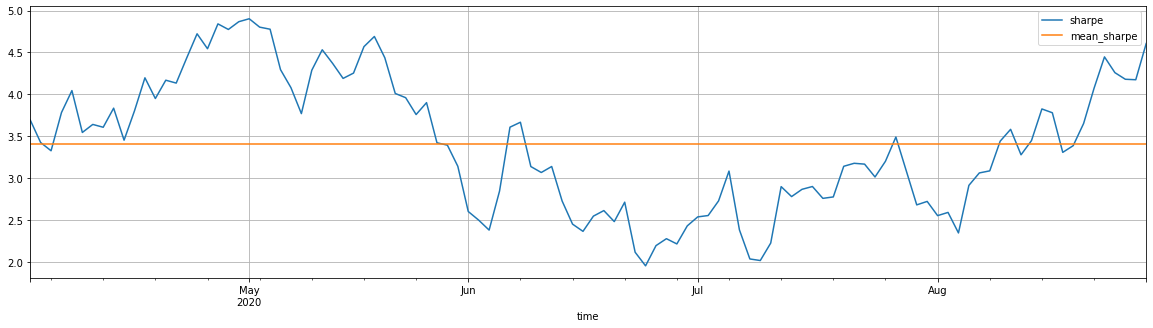

In [33]:
plot_rolling_sharpe(returns.total, 3)

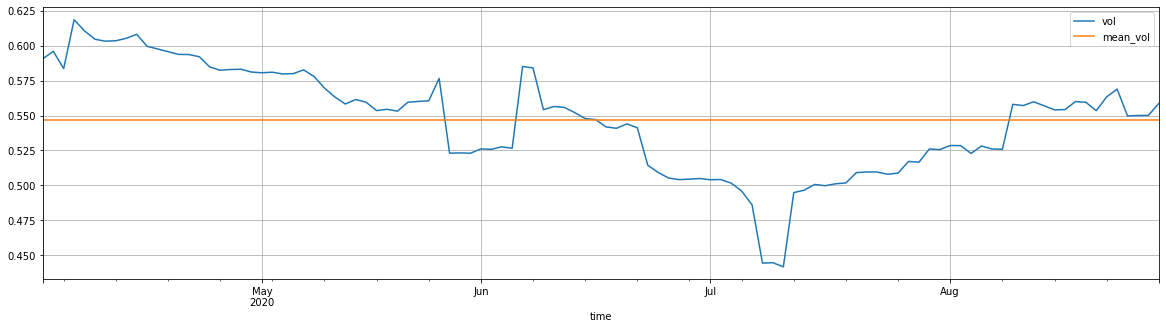

In [34]:
plot_rolling_vol(returns.total, 3)